In [7]:
import pandas as pd
import numpy as np
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

url = 'https://raw.githubusercontent.com/TheLazyCactus/ML_Project/refs/heads/main/Extra_data.csv'
df = pd.read_csv(url, sep=";", low_memory =False)

#url = 'https://raw.githubusercontent.com/TheLazyCactus/ML_Project/refs/heads/main/ML_Project_safety.csv'
#df1 = pd.read_csv(url, sep=";", low_memory =False)

Need to change the order to get the oldest value first

In [ ]:
#df1 = df1.sort_values(by="Year", ascending=True)

In [8]:
df.head()

,Year,Company code,Function,TRIR,LTIR
0,2014,A,Construction,"16,61","6,64"
1,2014,A,Drilling,"6,33","3,17"
2,2014,A,Exploration,"3,47",0
3,2014,A,Production,"7,07","3,03"
4,2014,A,Unspecified,"0,45","0,45"


In [ ]:
#Drop contractor/company division and FAR to have one database with activities?

Merge with other dataframe and rop the contractor/company difference

In [ ]:
# Merge on 'id' and 'year'
#merged_df = pd.merge(df1, df2, on=["Year", "Company code"], how="inner")

**EDA**

In [9]:
df.shape

(1852, 5)

In [10]:
cols = ["TRIR", "LTIR" ]  # List of columns to convert
df[cols] = df[cols].replace(',', '.', regex=True).astype(float)

df[cols] = df[cols].astype(float)


In [11]:
df.dtypes

Year              int64
Company code     object
Function         object
TRIR            float64
LTIR            float64
dtype: object

In [12]:
df.nunique()

Year             10
Company code     59
Function          6
TRIR            473
LTIR            234
dtype: int64

In [13]:
df.isna().sum()

Year             0
Company code     0
Function         0
TRIR            16
LTIR             0
dtype: int64

In [14]:
df = df.fillna(0)

In [39]:
df.columns

Index(['Year', 'Company code', 'FAR total', 'TRIR total', 'TRIR company only',
       'TRIR contractor only', 'LTIR total', 'LTIR company only',
       'LTIR contractor only'],
      dtype='object')

**Dummmies time**

In [15]:
df = pd.get_dummies(df, columns=["Company code", "Function"])
#get dummy for activity

**Train Test split**

*ARIMA*

In [18]:
pip install pmdarima --quiet

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
    --------------------------------------- 10.2/625.1 kB ? eta -:--:--
   -- ------------------------------------ 41.0/625.1 kB 653.6 kB/s eta 0:00:01
   ------------- -------------------------- 204.8/625.1 kB 1.8 MB/s eta 0:00:01
   -------------------------------- ------- 501.8/625.1 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 625.1/625.1 kB 3.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.4/2.8 MB 12.6 MB/s eta 0:00:01
   ------------ --------------------------- 0.8/2.8 MB 10.6 MB/s eta 0:00:01
   ------------------- -------------------- 1.3/2.8 MB 10.6 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 10.5 MB/s eta 0:00:01
   ------------------------------- -------- 2.2/2.8 MB 10.8 MB/s eta 0:00:01
   -------------------------------------- - 2.7/2.8 MB 10.7 MB/s eta 0:00:01
   ---

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [19]:
# standard ARIMA model
import pmdarima as pm
import matplotlib.pyplot as plt
ARIMA_model = pm.auto_arima(df["TRIR"],
                           start_p=1,
                           start_q=1,
                           test="adf",
                           max_p=3, max_q=3,
                           m=1, # frequency of the series if m==1 seasonal is set to FALSE automatically
                           d=None, # parameter that the algo will look for
                           seasonal=False, # no seasonality for std arima
                           trace=False, #logs
                           error_action="warn",
                           suppress_warnings=True,
                           stepwise=True)

print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1852
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -3974.533
Date:                Tue, 25 Feb 2025   AIC                           7955.065
Time:                        21:01:31   BIC                           7971.637
Sample:                             0   HQIC                          7961.174
                               - 1852                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3396      0.071     18.814      0.000       1.200       1.479
ar.L1          0.0920      0.020      4.561      0.000       0.052       0.132
sigma2         4.2813      0.035    122.635      0.0

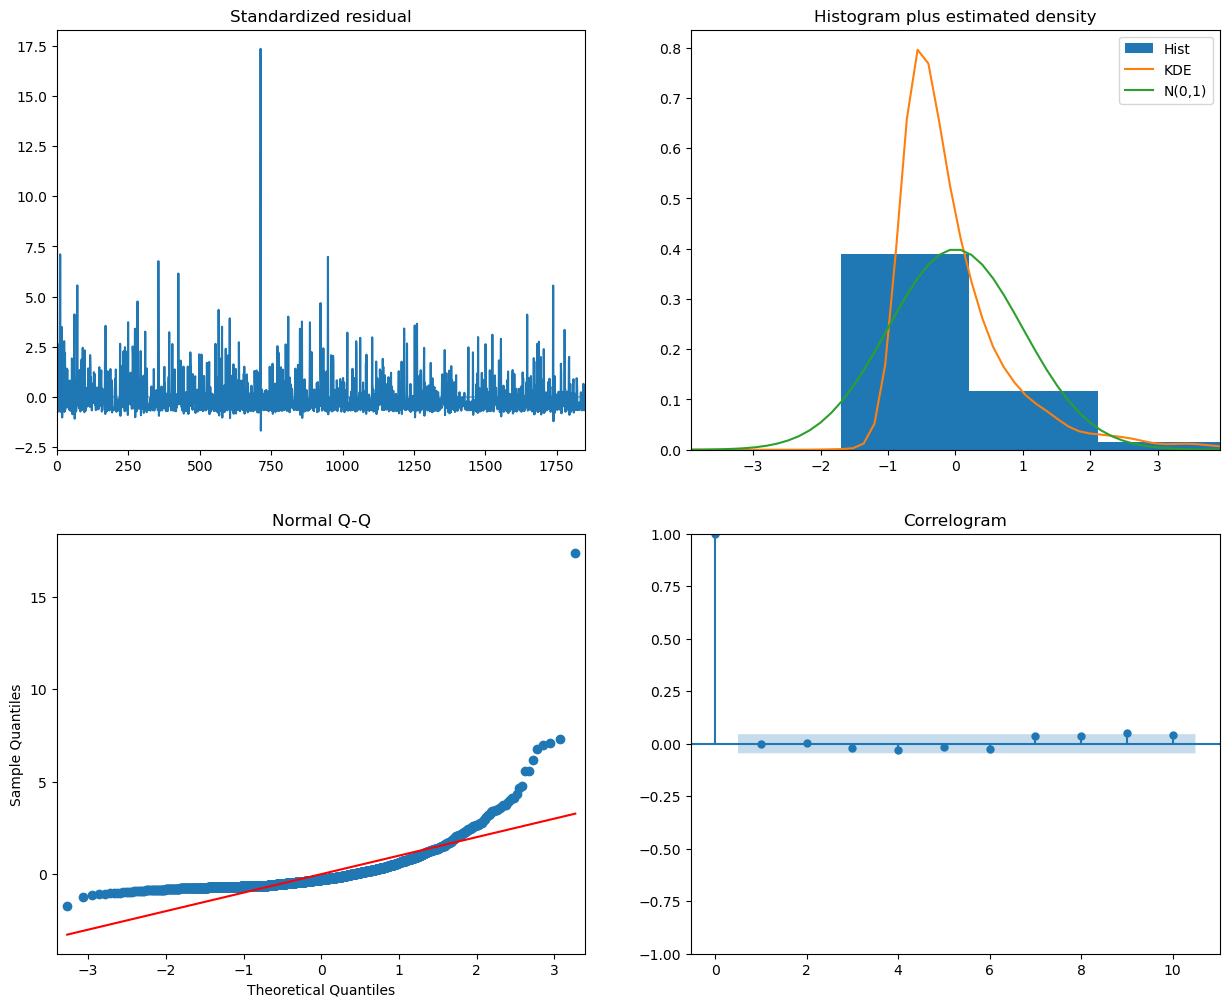

In [22]:
# diagnostics
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [20]:
def forecast(ARIMA_model, n_periods=24):
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1]+pd.DateOffset(year=1), periods=n_periods, freq="MS")

    # make the series for the plot
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:,0], index=index_of_fc)
    upper_series = pd.Series(confint[:,1], index=index_of_fc)


    #plot
    plt.figure(figsize=(15, 7))
    plt.plot(df["TRIR"], color="#1f76b4")
    plt.plot(fitted_series, color="darkgreen")
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color = "k",
                     alpha =.15)
    plt.title("ARIMA-Forecast TRIR")
    plt.show()

In [21]:
forecast(ARIMA_model, n_periods=24)

TypeError: unsupported operand type(s) for +: 'int' and 'DateOffset'

**Train test split**

In [44]:
# Define features (X) and targets (y)
X = df.drop(columns=["LTIR total", "LTIR company only", "LTIR contractor only"])  # Features
y = df[["LTIR total", "LTIR company only", "LTIR contractor only"]]  # Target variables

# Split the dataset (train on past data, test on future data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

**Model selection and evaluation only for LTIR using 2 other time series**

**Model stacking**

*Random forest*

In [63]:
#Class model
forest = RandomForestRegressor(n_estimators=100,
                             max_depth=10, random_state=42)
forest.fit(X_train, y_train)
pred = forest.predict(X_test)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score (Test)", forest.score(X_test, y_test))
print("R2 score (Train)", forest.score(X_train, y_train))

MAE 0.10721287031055741
RMSE 0.20366342931524148
R2 score (Test) 0.6110160765038436
R2 score (Train) 0.9498467843280824


d:\Data_analyst\Ironhack\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


For target with LTIR*3 and features with the rest
MAE 0.10721287031055741
RMSE 0.20366342931524148
R2 score (Test) 0.6110160765038436
R2 score (Train) 0.9498467843280824
Ok scores

*Bagging and Pasting*

In [55]:
bagging_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=10),
                               n_estimators=100,
                               max_samples=376,
                                random_state=42)#take 80% of the total samples

bagging_reg.fit(X_train, y_train)
pred = bagging_reg.predict(X_test)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", bagging_reg.score(X_test, y_test))

MAE 0.10437617101043273
RMSE 0.19848549053799866
R2 score 0.6348792593513751


d:\Data_analyst\Ironhack\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


For target with LTIR*3 and features with the rest
max depth =10
n=100
max samples =376

MAE 0.10437617101043273
RMSE 0.19848549053799866
R2 score 0.6348792593513751
Good scores

*Gradient Boosting*

In [57]:
print(y_train.shape)  # Should print (376,) not (376, 3)


(376, 3)


In [60]:
y_train_gb = y_train["LTIR total"] 
y_test_gb = y_test["LTIR total"]
gb_reg = GradientBoostingRegressor(max_depth=10,
                                   n_estimators=100,
                                   random_state=42)
gb_reg.fit(X_train, y_train_gb)
pred = gb_reg.predict(X_test)

print("MAE", mean_absolute_error(pred, y_test_gb))
print("RMSE", mean_squared_error(pred, y_test_gb, squared=False))
print("R2 score", gb_reg.score(X_test, y_test_gb))
print("R2 score", gb_reg.score(X_train, y_train_gb))

MAE 0.1117864129037802
RMSE 0.39307952363149157
R2 score -0.1412316209504969
R2 score 0.999999999294211


d:\Data_analyst\Ironhack\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


GB results (10,100,42):
MAE 0.1117864129037802
RMSE 0.39307952363149157
R2 score -0.1412316209504969
R2 score 0.999999999294211
Small R2

*Adaptive Boosting*

In [62]:
y_train_ab = y_train["LTIR total"] 
y_test_ab = y_test["LTIR total"]
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),
                            n_estimators=100,
                            random_state=42)
ada_reg.fit(X_train, y_train_ab)
pred = ada_reg.predict(X_test)

print("MAE", mean_absolute_error(pred, y_test_ab))
print("RMSE", mean_squared_error(pred, y_test_ab, squared=False))
print("R2 score", ada_reg.score(X_test, y_test_ab))
print("R2 score", ada_reg.score(X_train, y_train_ab))

MAE 0.04495567375886524
RMSE 0.18898996261512713
R2 score 0.7361904989257821
R2 score 0.9989796794681831


d:\Data_analyst\Ironhack\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Ab results (10,100,42):
MAE 0.04495567375886524
RMSE 0.18898996261512713
R2 score 0.7361904989257821
R2 score 0.9989796794681831
Best score

Logistic regression ?
Sarimax = exogenous feature ? (Used for air pollution prediction) without it's Sarima

*SARIMA*

*Logistic regression*

**Overfitting?**

**Cross validation**

**Using the model for prediction**

In [52]:
future_years = np.array(range(2025, 2031)).reshape(-1, 1)
future_df = pd.DataFrame({"Year": future_years.flatten()})

# Step 1: Create lag and rolling mean features for future data
for col in ["FAR total", "TRIR total", "TRIR company only", "TRIR contractor only", "LTIR total", "LTIR company only", "LTIR contractor only"]:
    future_df[f"{col}_lag1"] = np.nan  # Placeholder for lag1
    future_df[f"{col}_lag2"] = np.nan  # Placeholder for lag2
    future_df[f"{col}_rolling_mean"] = np.nan  # Placeholder for rolling mean



In [61]:
# Step 2: One-hot encode the 'Company code' for future data
companies = df['Company code'].unique()  # Get unique company codes used in training
company_cols = [f'Company_{company}' for company in companies]  # List of one-hot encoded company columns

company_cols 

['Company_E         ',
 'Company_F         ',
 'Company_G         ',
 'Company_H         ',
 'Company_I         ',
 'Company_J         ',
 'Company_K         ',
 'Company_L         ',
 'Company_M         ',
 'Company_N         ',
 'Company_O         ',
 'Company_P         ',
 'Company_Q         ',
 'Company_R         ',
 'Company_S         ',
 'Company_T         ',
 'Company_V         ',
 'Company_W         ',
 'Company_X         ',
 'Company_Y         ',
 'Company_Overall   ',
 'Company_AA        ',
 'Company_BB        ',
 'Company_CC        ',
 'Company_DD        ',
 'Company_EE        ',
 'Company_FF        ',
 'Company_GG        ',
 'Company_HH        ',
 'Company_II        ',
 'Company_KK        ',
 'Company_LL        ',
 'Company_MM        ',
 'Company_NN        ',
 'Company_OO        ',
 'Company_PP        ',
 'Company_QQ        ',
 'Company_RR        ',
 'Company_SS        ',
 'Company_TT        ',
 'Company_UU        ',
 'Company_VV        ',
 'Company_WW        ',
 'Company_A

In [58]:
# Initialize with zeros for future_df (since future_df doesn't have companies yet, assume 0s)
for col in company_cols:
    future_df[col] = 0

# Step 3: Add lag and rolling mean data from the most recent year in the historical data
# We'll take the last row of your historical data (i.e., the latest year) and use it for future data as placeholders.
latest_data = model_df.iloc[-1]

# Loop through each feature to assign the latest available data for the future years
for col in ["FAR total", "TRIR total", "TRIR company only", "TRIR contractor only", "LTIR total", "LTIR company only", "LTIR contractor only"]:
    future_df[f"{col}_lag1"] = latest_data[col]  # Assign latest value as lag1 for future
    future_df[f"{col}_lag2"] = latest_data[col]  # Assign latest value as lag2 for future
    future_df[f"{col}_rolling_mean"] = latest_data[col]  # Use latest value as rolling mean placeholder



In [59]:
# Step 4: Align features for future data (same as used in training)
# Assuming the model was trained with the same set of features, align these columns for prediction.
future_df_with_features = future_df[["Year"] + company_cols + 
                                     ["FAR total_lag1", "FAR total_lag2", "FAR total_rolling_mean", 
                                      "TRIR total_lag1", "TRIR total_lag2", "TRIR total_rolling_mean", 
                                      "LTIR total_lag1", "LTIR total_lag2", "LTIR total_rolling_mean"]]



In [60]:
# Step 5: Use the trained model to predict future values
# Assuming that your model has already been trained, use it to predict.
future_predictions = model.predict(future_df_with_features)

# Step 6: Store predictions in the dataframe
future_df[["TRIR total", "TRIR company only", "TRIR contractor only", "LTIR total", "LTIR company only", "LTIR contractor only"]] = future_predictions

# Step 7: Print out the future predictions dataframe
print(future_df)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Company_00        
- Company_A         
- Company_AA        
- Company_AAA       
- Company_B         
- ...
Feature names seen at fit time, yet now missing:
- Company code_A         
- Company code_AA        
- Company code_AAA       
- Company code_B         
- Company code_BB        
- ...


In [22]:
for col in ["FAR total", "TRIR total", "TRIR company only","TRIR contractor only", "LTIR total", "LTIR company only", "LTIR contractor only" ]:
    df[f"{col}_rolling_mean"] = df[col].rolling(window=3).mean()
df.dropna(inplace=True)  # Drop NaN values created by shifting

In [23]:
df = pd.get_dummies(df, columns=["Company code"], drop_first=True)

Sans FAR

In [32]:
from sklearn.model_selection import train_test_split

# Define features (X) and targets (y)
X = df.drop(columns=["FAR total", "TRIR total", "TRIR company only","TRIR contractor only", "LTIR total", "LTIR company only", "LTIR contractor only"])  # Features
y = df[[ "TRIR total", "TRIR company only","TRIR contractor only", "LTIR total", "LTIR company only", "LTIR contractor only"]]  # Target variables

# Split the dataset (train on past data, test on future data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Initialize model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.3491333333333333


In [35]:
import numpy as np
import pandas as pd

# Step 1: Prepare the future years (2025-2030)
future_years = np.array(range(2025, 2031)).reshape(-1, 1)  # Example: Predict for 2025-2030

# Create a DataFrame for future years
future_df = pd.DataFrame({"Year": future_years.flatten()})

# Step 2: One-hot encode the company column for the future data (like you did during training)
# Assuming df has the 'Company code' column from the original dataset
companies = df['Company code'].unique()  # Get unique company codes used in training

# Make sure that 'Company code' column exists in the future_df (otherwise, add it)
# Add a placeholder company data for future predictions (you can modify this as needed)
future_df['Company code'] = companies[0]  # This is just an example, adjust as needed

# One-hot encode the 'Company code' column (future_df should have the same structure as training data)
future_companies_df = pd.get_dummies(future_df['Company code'], prefix='Company', columns=companies)

# Add missing columns for companies not in future data
for company in companies:
    if f'Company_{company}' not in future_companies_df.columns:
        future_companies_df[f'Company_{company}'] = 0

# Concatenate one-hot encoded columns to future_df
future_df = pd.concat([future_df, future_companies_df], axis=1)

# Step 3: Use the trained model to predict future values
# Assuming the model is already trained, you can now make predictions on future_df
future_predictions = model.predict(future_df)

# Step 4: Store predictions in the dataframe
future_df[[ "TRIR total", "TRIR company only", "TRIR contractor only", "LTIR total", "LTIR company only", "LTIR contractor only"]] = future_predictions

# Step 5: Print out the future predictions dataframe
print(future_df)


KeyError: 'Company code'